In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [2]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=234):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname), encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

# Load data:

In [3]:
((train_texts, train_labels), (test_texts, test_labels)) = load_imdb_sentiment_analysis_dataset("C:\\03.Data")

# Inspecting data:

In [5]:
print(train_labels.shape)
print(np.unique(train_labels))
print(np.unique(test_labels))
print(train_texts[10])
print(train_labels[10])
print(train_texts[1111])
print(train_labels[1111])

(25000,)
[0 1]
[0 1]
This is one of my favorite family movies. Loved it when I was little and it still holds up with me now that I'm older. I still laugh at all the same old jokes and might even shed a tear a times. I never have much cared for animals talking, or at least UN-animated ones but this one I'll stand up for. It's a pretty old movie but it will always hold a place in my heart.<br /><br />There aren't any other live animal movies that I can think of at the moment that I even could compare with, let alone like as much as this one. I might be giving too much praise to this movie but I don't think show. I really holds that great message that" Home is where the heart is." Or at least that's the message I gained from it. Definitely recommended for a good old family movie night.
1
I found this on the shelf while housesitting and bored. How can people possibly give this a 10? It's not just that it's supposed to be a feel-good redemption film (I think), because it doesn't work on tha

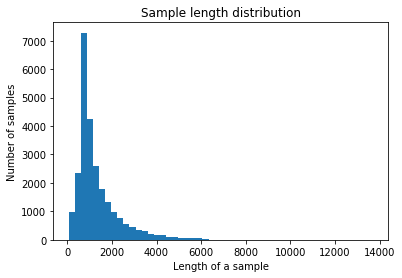

In [6]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    
plot_sample_length_distribution(train_texts)

# Tokenize and normalize text, by uisng n-gram option:

In [7]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val, vectorizer, selector

In [8]:
x_trains, x_test, vectorizer, selector = ngram_vectorize(train_texts, train_labels, test_texts)

trainLen = len(train_texts)
ratio = 0.8

x_train= x_trains[0: int(trainLen*ratio)]
train_label = train_labels[0: int(trainLen*ratio)]
x_val= x_trains[int(trainLen*ratio): trainLen]
val_label = train_labels[int(trainLen*ratio): trainLen]

C:\Users\xiaop\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


# Inspect vectorized samples:

In [14]:
print(type(x_train))
print(x_train.shape)
#print(x_train[0])
print(x_train[0])

<class 'scipy.sparse.csr.csr_matrix'>
(20000, 20000)
  (0, 222)	0.040014867
  (0, 234)	0.0320392
  (0, 326)	0.058605377
  (0, 603)	0.05341435
  (0, 611)	0.04135849
  (0, 680)	0.040576857
  (0, 769)	0.04888433
  (0, 1013)	0.03788184
  (0, 1275)	0.0412489
  (0, 1492)	0.052573945
  (0, 1495)	0.041906845
  (0, 1636)	0.033329703
  (0, 1647)	0.011337811
  (0, 1722)	0.021325056
  (0, 1775)	0.013066896
  (0, 1788)	0.02691619
  (0, 2259)	0.056404907
  (0, 2263)	0.03441264
  (0, 2366)	0.0436179
  (0, 2729)	0.0376579
  (0, 2741)	0.048326466
  (0, 2757)	0.024164308
  (0, 3107)	0.027695298
  (0, 3320)	0.09595785
  (0, 3452)	0.035089932
  :	:
  (0, 16141)	0.032155022
  (0, 16152)	0.028531682
  (0, 16190)	0.028467992
  (0, 16263)	0.026278986
  (0, 16447)	0.030293142
  (0, 16553)	0.04528116
  (0, 16839)	0.054779865
  (0, 16941)	0.0416279
  (0, 16989)	0.017922325
  (0, 17166)	0.022838412
  (0, 17213)	0.025983071
  (0, 17324)	0.03211185
  (0, 17553)	0.033501253
  (0, 17878)	0.0401723
  (0, 17960)	0.0359

# Another preprocessing option, convert text to sequenc model:

In [15]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

# determine layer type and unit number for last layer:

In [17]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

# define  multi-layer perceptrons (MLPs) model for n-gram option:

In [18]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(2)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

# training process for n-gram model:

In [20]:
def train_ngram_model(learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=32,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    
    num_classes=2

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=2)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_label,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_label),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    #check if model works as expected:
    print("check on train data:")
    results = model.evaluate(x_train, train_label)
    print(model.metrics_names)
    print(results)
    
    print("check on val data:")
    results = model.evaluate(x_val, val_label)
    print(model.metrics_names)
    print(results)

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return model, history['val_acc'][-1], history['val_loss'][-1]

In [21]:
imdbModel, _, _ = train_ngram_model()

Train on 20000 samples, validate on 5000 samples
Epoch 1/1000
20000/20000 - 17s - loss: 0.5626 - acc: 0.8422 - val_loss: 0.4153 - val_acc: 0.8948
Epoch 2/1000
20000/20000 - 16s - loss: 0.3311 - acc: 0.8986 - val_loss: 0.2754 - val_acc: 0.9120
Epoch 3/1000
20000/20000 - 16s - loss: 0.2348 - acc: 0.9230 - val_loss: 0.2232 - val_acc: 0.9234
Epoch 4/1000
20000/20000 - 16s - loss: 0.1863 - acc: 0.9379 - val_loss: 0.1981 - val_acc: 0.9304
Epoch 5/1000
20000/20000 - 16s - loss: 0.1574 - acc: 0.9484 - val_loss: 0.1838 - val_acc: 0.9336
Epoch 6/1000
20000/20000 - 16s - loss: 0.1368 - acc: 0.9551 - val_loss: 0.1746 - val_acc: 0.9350
Epoch 7/1000
20000/20000 - 16s - loss: 0.1178 - acc: 0.9618 - val_loss: 0.1697 - val_acc: 0.9374
Epoch 8/1000
20000/20000 - 16s - loss: 0.1028 - acc: 0.9685 - val_loss: 0.1650 - val_acc: 0.9356
Epoch 9/1000
20000/20000 - 16s - loss: 0.0918 - acc: 0.9722 - val_loss: 0.1628 - val_acc: 0.9362
Epoch 10/1000
20000/20000 - 16s - loss: 0.0803 - acc: 0.9759 - val_loss: 0.162

# Evaluate the model:

In [22]:
results = imdbModel.evaluate(x_test, test_labels)
print(imdbModel.metrics_names)
print(results)

4000/4000 [==============================] - 1s 185us/sample - loss: 0.2604 - acc: 0.9005
['loss', 'acc']
[0.2603893958628178, 0.9005]


# Get test data, predict:

In [23]:
testStrings = []
testLabels = []
    
for category in ['pos', 'neg']:
    test_path = os.path.join("C:\\03.Data\\aclImdb", 'test', category)
    for fname in sorted(os.listdir(test_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                testStrings.append(f.read())
            testLabels.append(0 if category == 'neg' else 1)
            
seedTest = 987
random.seed(seedTest)
random.shuffle(testStrings)
random.seed(seedTest)
random.shuffle(testLabels)

# shuffle, and check some original text:

In [24]:
print(testStrings[114])
print(testLabels[114])
print(testStrings[786])
print(testLabels[786])

people, get a clue! I mean, the writers dont have one, so I would expect you to...this show is SUCH a pale imitation of the '60 show that you can laugh at it! and the sixties show is the one with the cheap special effects, and is in B&W fer Chrissakes! Yet the mood and the writing on the old show is MILES ahead of this drivel. Get HiP kids! if 98 Degrees or Brittany told you to watch it, you would! You know it! Just bypass them and tell all your friends you were 'IN' with the 'scene' BEFORE it became too cool!
0
I loved it. In fact, I watched it over and over and over, and I could watch it again. This movie doesn't get boring.<br /><br />The vampire concept is revolutionized in this movie. It's a job well done, great for today's generation.<br /><br />Wesley Snipes was born for this role. Stephen Dorff was an ideal vampire. Arly Jover, mmmm mmm, she can bite me any time she wants and what a sexy accent she has. Donal Logue provides great comical relief.<br /><br />This vampire movie is

# predict:

In [25]:
x_index = 1901

x_test = vectorizer.transform(testStrings[x_index: x_index+1])
x_test = selector.transform(x_test).astype('float32')

x_predict = imdbModel.predict(x_test)

print(testStrings[x_index])
print("real value: %d" % testLabels[x_index])
print(x_predict)

This film is so bad. I mean, who commissions this stuff? And the costume designer deserves an award for making everyone look like they had just stepped out of 1983. A bloke puts a female wig on and fights....nuff said.
real value: 0
[[0.01965372]]


# real comment from internet:

In [26]:
s = "I am very, very tied on this film. On one hand, I thought Bohemian Rhapsody tributed the story of Freddie Mercury-for the most part-judiciously, mainly due to Rami Malek's immersive performance. Trust me, if Malek wasn't in this movie, Bohemian Rhapsody would've crumbled to ashes apace with some of the biggest catastrophes of 2018. As a depiction and honory of a musical legend, I was earnestly contented to witness the results. On the other hand, I found this movie to be a pretty incoherent, potboiler mess of a product. The harshest way to submit this is, well, simply put, to say that Bohemian Rhapsody is fundamentally your average company manufactured, cop-out, strand of merchandise that was only fabricated for mainstream audiences who will unknowingly be able to eat up the same old Fast and the Furious: Family is Important blueprint that they've unconsciously seen billions of times. However, this movie is dang LUCKY that they got Malek on the project and that they AT LEAST managed to make a glaringly enthralling, two-hour, sound-explosion of a music video.."

sList = [s]
x_real = vectorizer.transform(sList)
x_real = selector.transform(x_real).astype('float32')

x_predict = imdbModel.predict(x_real)

print(s)
print(x_predict)

I am very, very tied on this film. On one hand, I thought Bohemian Rhapsody tributed the story of Freddie Mercury-for the most part-judiciously, mainly due to Rami Malek's immersive performance. Trust me, if Malek wasn't in this movie, Bohemian Rhapsody would've crumbled to ashes apace with some of the biggest catastrophes of 2018. As a depiction and honory of a musical legend, I was earnestly contented to witness the results. On the other hand, I found this movie to be a pretty incoherent, potboiler mess of a product. The harshest way to submit this is, well, simply put, to say that Bohemian Rhapsody is fundamentally your average company manufactured, cop-out, strand of merchandise that was only fabricated for mainstream audiences who will unknowingly be able to eat up the same old Fast and the Furious: Family is Important blueprint that they've unconsciously seen billions of times. However, this movie is dang LUCKY that they got Malek on the project and that they AT LEAST managed to 